# ML Pipeline Studio - Workflow to Develop Model Training on Vertex AI

1. Define a common sense baseline model

We will create a naive forecast, where we will use the mtb from the previous trip to predict the next trip and measure accuracy

2. Scale up by developing a model that will overfit, showing statisical power

Durring this phase, we will experiment with different datasets and different model architecture.

3. Regularize and tune
Once we establish a model that shows sufficient representational power, we will look to improve accuracy through hp tuning and regularization

In [1]:
import pandas as pd

data = pd.read_csv('full_clean_ml_datset.csv')

data.shape

(108697, 12)

In [2]:
data.head()

,arrival_date,duration,mbt,temp,precip,snow,snowdepth,visibility,windspeed,rolling_mean_10,rolling_std_10,rolling_mean_50
0,2024-01-01 00:01:07,24.67,12.95,43.1,0.0,0.0,0.0,9.9,6.1,14.153,5.618179,15.944
1,2024-01-01 00:11:54,25.95,10.78,43.1,0.0,0.0,0.0,9.9,6.1,14.153,5.618179,15.944
2,2024-01-01 00:23:12,24.83,11.30,43.1,0.0,0.0,0.0,9.9,6.1,14.153,5.618179,15.944
3,2024-01-01 00:34:05,24.02,10.88,42.2,0.0,0.0,0.0,9.9,6.9,14.153,5.618179,15.944
4,2024-01-01 00:49:29,26.87,15.40,42.2,0.0,0.0,0.0,9.9,6.9,14.153,5.618179,15.944


In [3]:
data['arrival_date'] = pd.to_datetime(data['arrival_date'])

time_diff =  data['arrival_date'].iloc[175] - data['arrival_date'].iloc[0]

diff_in_hours = time_diff.total_seconds() / 3600

print(f"time difference: {time_diff}")
print(f"Time difference in hours: {diff_in_hours:.2f}")

time difference: 1 days 14:16:32
Time difference in hours: 38.28


In [4]:
data['year'] = data['arrival_date'].dt.year
year_counts = data['year'].value_counts().sort_index()
print("Number of examples per year:")
print(year_counts)

Number of examples per year:
year
2024    55733
2025    52964
Name: count, dtype: int64


In [5]:
data = data[data['year'].isin([2024, 2025])]
print("Data filtered to include only years 2024 and 2025.")
print(data['year'].value_counts().sort_index())

Data filtered to include only years 2024 and 2025.
year
2024    55733
2025    52964
Name: count, dtype: int64


In [6]:
data.iloc[:, 1:].describe().T

,count,mean,std,min,25%,50%,75%,max
duration,108697.0,29.708229,7.012662,0.13000,25.670000,27.330000,30.580000,148.470000
mbt,108697.0,8.201590,5.365014,0.00000,4.380000,6.830000,10.750000,30.000000
temp,108697.0,58.260465,16.970698,11.10000,45.000000,59.800000,72.100000,98.000000
precip,108697.0,0.004378,0.034934,0.00000,0.000000,0.000000,0.000000,1.998000
snow,108697.0,0.002400,0.041019,0.00000,0.000000,0.000000,0.000000,3.190000
snowdepth,108697.0,0.077414,0.357206,0.00000,0.000000,0.000000,0.000000,5.040000
visibility,108697.0,9.172200,1.897825,0.00000,9.900000,9.900000,9.900000,9.900000
windspeed,108697.0,6.330647,4.390730,0.00000,3.700000,5.900000,8.600000,34.900000
rolling_mean_10,108697.0,8.201463,3.931409,2.24200,5.373000,6.491000,10.794000,23.686000
rolling_std_10,108697.0,3.489552,1.621642,0.52426,2.319373,3.041904,4.282446,11.045033


In [7]:
data = data.drop(columns=['year'], axis=1)

In [8]:
data.head()

,arrival_date,duration,mbt,temp,precip,snow,snowdepth,visibility,windspeed,rolling_mean_10,rolling_std_10,rolling_mean_50
0,2024-01-01 00:01:07,24.67,12.95,43.1,0.0,0.0,0.0,9.9,6.1,14.153,5.618179,15.944
1,2024-01-01 00:11:54,25.95,10.78,43.1,0.0,0.0,0.0,9.9,6.1,14.153,5.618179,15.944
2,2024-01-01 00:23:12,24.83,11.30,43.1,0.0,0.0,0.0,9.9,6.1,14.153,5.618179,15.944
3,2024-01-01 00:34:05,24.02,10.88,42.2,0.0,0.0,0.0,9.9,6.9,14.153,5.618179,15.944
4,2024-01-01 00:49:29,26.87,15.40,42.2,0.0,0.0,0.0,9.9,6.9,14.153,5.618179,15.944


In [9]:
data.to_csv('new_full_dataset.csv', header=True, index=False)

In [10]:
import os
from matplotlib import pyplot as plt
import numpy as np
import os
from tensorflow import keras
from tensorflow.keras import layers
import model_utils as utils
os.environ['TF_CPP_MINM_LOG_LEVEL'] = '2'

In [11]:
plt.rcParams["figure.figsize"] = (9,6)

In [12]:

fname = os.path.join('new_full_dataset.csv')

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['arrival_date', 'duration', 'mbt', 'temp', 'precip', 'snow', 'snowdepth', 'visibility', 'windspeed', 'rolling_mean_10', 'rolling_std_10', 'rolling_mean_50']
108698


In [13]:
lines = [line for line in lines if line.strip()]

mbt = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    mbt[i] = values[1]
    raw_data[i, :] = values[:]

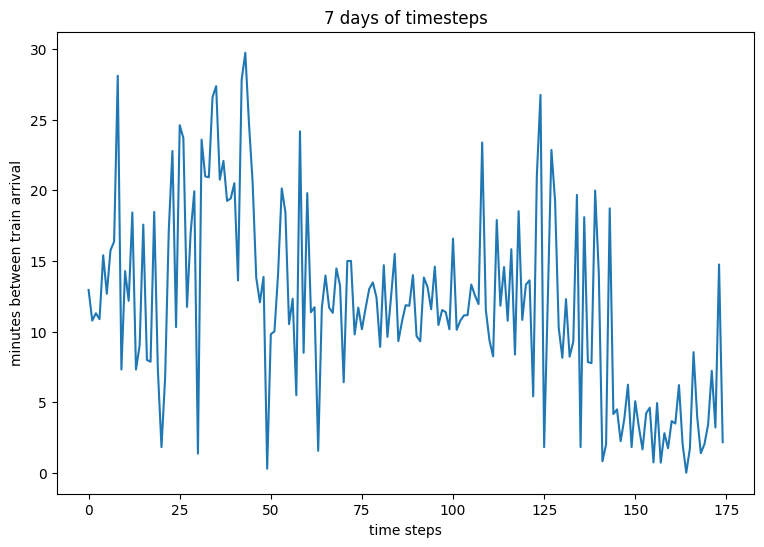

In [14]:
plt.plot(range(len(mbt[0:175])), mbt[0:175])
plt.title('7 days of timesteps')
plt.ylabel('minutes between train arrival')
plt.xlabel('time steps');

In [15]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("Training Samples:", num_train_samples)
print("Validation Samples:", num_val_samples)
print("Test Samples:", num_test_samples)

Training Samples: 54348
Validation Samples: 27174
Test Samples: 27175


In [16]:
# Standard scaling: (x - mean) / std
# Apply to all columns except the target if needed

# If your target is included in raw_data, exclude it from scaling
# For this example, let's assume all columns should be scaled
train_mean = np.mean(raw_data[:num_train_samples, :], axis=0)
train_std = np.std(raw_data[:num_train_samples, :], axis=0)

# Apply standard scaling to all columns
raw_data = (raw_data - train_mean) / train_std

# Verify the range
print("Means after scaling (should be ~0):", np.mean(raw_data, axis=0))
print("Stds after scaling (should be ~1):", np.std(raw_data, axis=0))


Means after scaling (should be ~0): [-0.02281723  0.02598049 -0.0617008   0.0015166  -0.00485714 -0.00658865
 -0.0236743   0.04608616  0.03582403 -0.03601967  0.04604678]
Stds after scaling (should be ~1): [0.98712852 1.00311506 1.05085521 1.24443158 1.01660829 0.89744881
 1.01713738 1.03659929 1.01670188 1.00762106 1.02072925]


In [17]:
import tensorflow as tf
from tensorflow import keras

# --- Configuration ---
sequence_length = 195 # represents roughly 24 hrs of train arrivals
batch_size = 128 # consider A100 gpu

# Uses the first 50% of data (0 to num_train_samples)
train_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-sequence_length],  # Inputs
    targets=mbt[sequence_length:, None],     # Targets (shifted by seq_length)
    sequence_length=sequence_length,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=True,                      # Shuffle ONLY for training
    start_index=0,
    end_index=num_train_samples
)

# --- 2. Validation Dataset ---
# Uses the next 25% of data
val_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-sequence_length],
    targets=mbt[sequence_length:, None],
    sequence_length=sequence_length,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,                     # No shuffle for validation
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

# --- 3. Test Dataset ---
# Uses the remaining data
test_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-sequence_length],
    targets=mbt[sequence_length:, None],
    sequence_length=sequence_length,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,                     # No shuffle for testing
    start_index=num_train_samples + num_val_samples,
    end_index=None                     # Go to the end
)

# --- Verification ---
for inputs, targets in train_dataset.take(1):
    print(f"Input shape: {inputs.shape}")   # (256, 186, 10) -> (Batch, Time, Features)
    print(f"Target shape: {targets.shape}") # (256,)         -> (Batch,)

Input shape: (128, 195, 11)
Target shape: (128, 1)


In [18]:
for inputs, targets in train_dataset.take(1):
    # Select the first example from the batch
    first_input_example = inputs[0]
    first_target_example = targets[0]

    print(f"Shape of one input example: {first_input_example.shape}")
    print(f"Shape of one target example: {first_target_example.shape}")
    print("\nFirst few features of the input example (first 5 timesteps, first 5 features):")
    print(first_input_example[:5, :5])
    print("\nTarget for this example:")
    print(first_target_example)

Shape of one input example: (195, 11)
Shape of one target example: (1,)

First few features of the input example (first 5 timesteps, first 5 features):
tf.Tensor(
[[-0.22808392 -0.89610006 -0.93854554 -0.15443813 -0.06432591]
 [-0.05212843 -1.35418704 -0.93854554 -0.15443813 -0.06432591]
 [-0.40685469 -0.61937813 -0.93854554 -0.15443813 -0.06432591]
 [-0.33365721 -0.36696286 -0.93854554 -0.15443813 -0.06432591]
 [-0.35899479 -1.47572032 -0.93854554 -0.15443813 -0.06432591]], shape=(5, 5), dtype=float64)

Target for this example:
tf.Tensor([1.67], shape=(1,), dtype=float64)


In [19]:
def run_experiment(model, train_ds, val_ds, model_name, epochs=50, patience=5):

    # 1. Optimization Schedule
    # Cosine Decay is excellent, but let's try a slightly more aggressive decay
    lr_schedule = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=0.001,
        decay_steps=epochs * len(train_ds),
        alpha=0.001 # Decays to 1e-6
    )

    # 2. Callbacks
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=f"{model_name}.keras",
            save_best_only=True,
            monitor="val_loss",
            mode="min",
            verbose=0
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=patience,
            restore_best_weights=True,
            verbose=1
        )
    ]

    # 3. Compile
    # Using AdamW (Adam with Weight Decay) for better generalization
    # Using Huber loss for robust regression
    model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-4),
        loss=keras.losses.Huber(delta=1.0),
        metrics=["mae"]
    )

    # 4. Fit
    print(f"\nStarting training for: {model_name}")
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        callbacks=callbacks,
        verbose=1
    )

    return history

# Architecture Experiments

We will experiment with the following architectures:
- Densly Connected Model
- Simple LSTM
- Otimized GRU

# Common Sense Baseline

First we will start with a naive forecast, using the final step in a sequence to predict the next step.  This baseline metric will serve as the benchmark to beat, where we can train a model that shows more statistical power than a random guess.

In [20]:
def evaluate_naive_method(dataset, train_mean, train_std):
    total_abs_err = 0.0
    samples_seen = 0

    # For standard scaling, use mean and std for inverse transform (mbt is column 1)
    mbt_mean = train_mean[1]
    mbt_std = train_std[1]

    for samples, targets in dataset:
        # 1. Get the standardized value from the last time step of the input
        # Shape: (Batch_Size,)
        scaled_last_step = samples[:, -1, 1]

        # 2. Inverse transform to get Real Minutes
        pred_minutes = (scaled_last_step * mbt_std) + mbt_mean

        # 3. Get Targets (already in Real Minutes)
        real_targets = targets.numpy().flatten()

        # 4. Calculate Error (MAE) in Real Minutes
        total_abs_err += np.sum(np.abs(pred_minutes - real_targets))
        samples_seen += samples.shape[0]

    return total_abs_err / samples_seen

print(f"Validation MAE (Real Minutes): {evaluate_naive_method(val_dataset, train_mean, train_std):.2f}")
print(f"Test MAE (Real Minutes): {evaluate_naive_method(test_dataset, train_mean, train_std):.2f}")

Validation MAE (Real Minutes): 4.22
Test MAE (Real Minutes): 4.01


# Interpretation

# Densly Connected Model

In [21]:
model_name = 'Dense Model'

# start with model architecture
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# replace Flatten with Reshape
x = layers.Reshape((sequence_length * raw_data.shape[-1],))(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
dense_model = keras.Model(inputs, outputs)

history_dense = run_experiment(
    model=dense_model,
    train_ds=train_dataset,
    val_ds=val_dataset,
    model_name=model_name,
    epochs=20,
    patience=5)


Starting training for: Dense Model
Epoch 1/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.0740 - mae: 3.5401 - val_loss: 2.8224 - val_mae: 3.2855
Epoch 2/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.4908 - mae: 2.9471 - val_loss: 2.7365 - val_mae: 3.1978
Epoch 3/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.4007 - mae: 2.8575 - val_loss: 2.6968 - val_mae: 3.1568
Epoch 4/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.3283 - mae: 2.7820 - val_loss: 2.7095 - val_mae: 3.1706
Epoch 5/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.2991 - mae: 2.7522 - val_loss: 2.6379 - val_mae: 3.0976
Epoch 6/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.2677 - mae: 2.7190 - val_loss: 2.6694 - val_mae: 3.1303
Epoch 7/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.2272 - mae: 2.6775 - val_loss: 2.6337 - val_mae: 3.0947
Epoch 8/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.2073 - mae: 2.6569 - val_loss: 2.6246 - val_mae: 3.0847
Epoch 9/20
424/424 ━

In [22]:
utils.evaluate_model(f"{model_name}.keras", test_dataset)

Loading best model from: Dense Model.keras
Evaluating model on test set...
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3361 - mae: 2.7897
Test MAE: 2.6961


2.6960697174072266

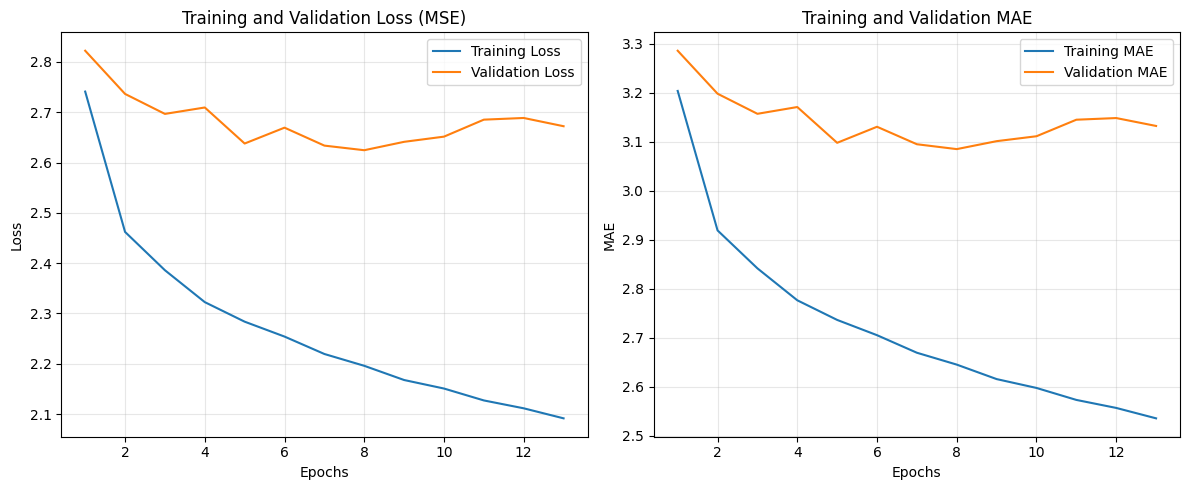

In [23]:
utils.plot_training_history(history_dense, metrics=['mae'])

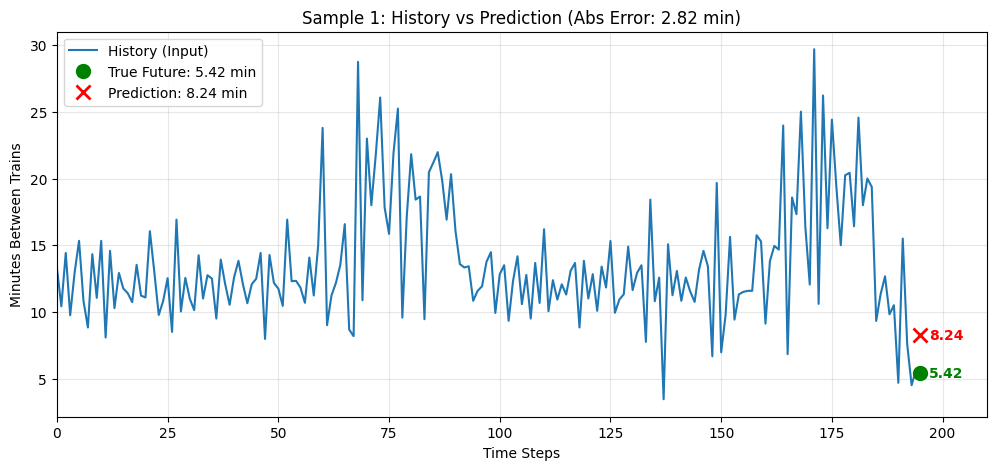

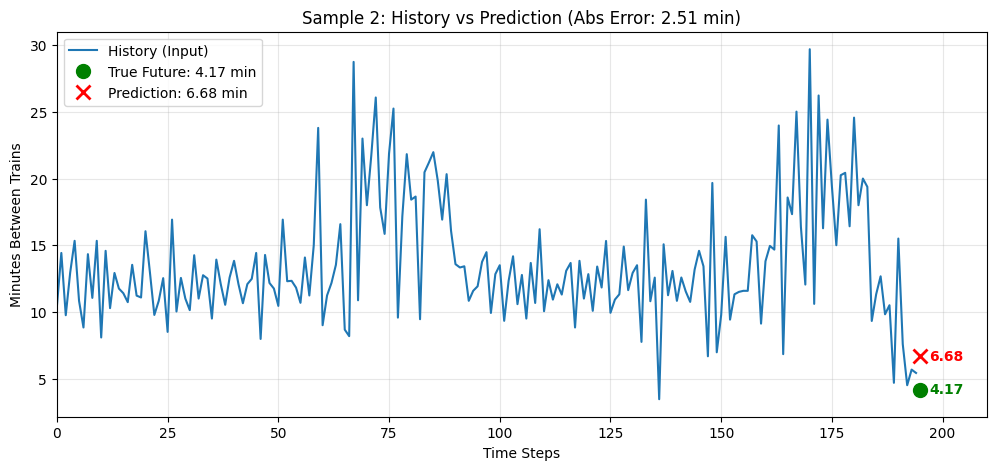

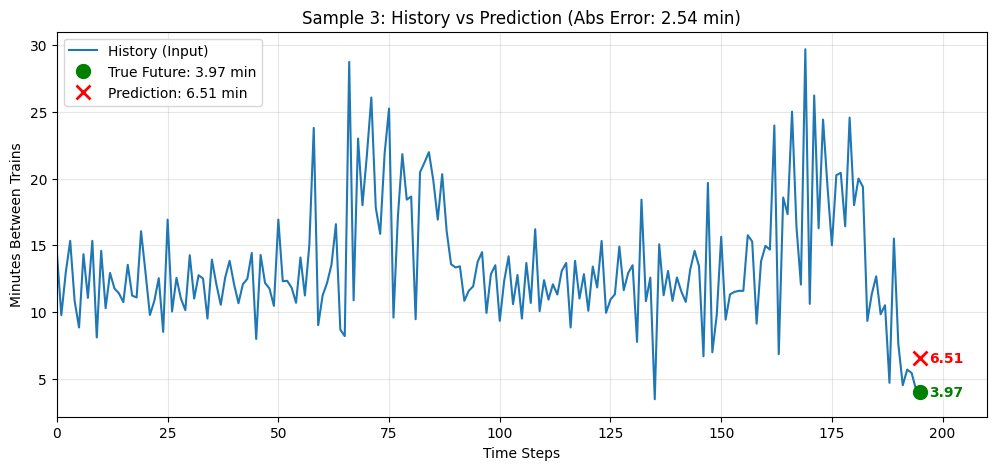

In [24]:
# Use model_name as path for forecast context and prediction distribution
utils.plot_forecast_context(
    model_path=f"{model_name}.keras",
    dataset=test_dataset,
    train_mean=train_mean,
    train_std=train_std,
    num_samples=3  # Optional: How many examples to plot
)

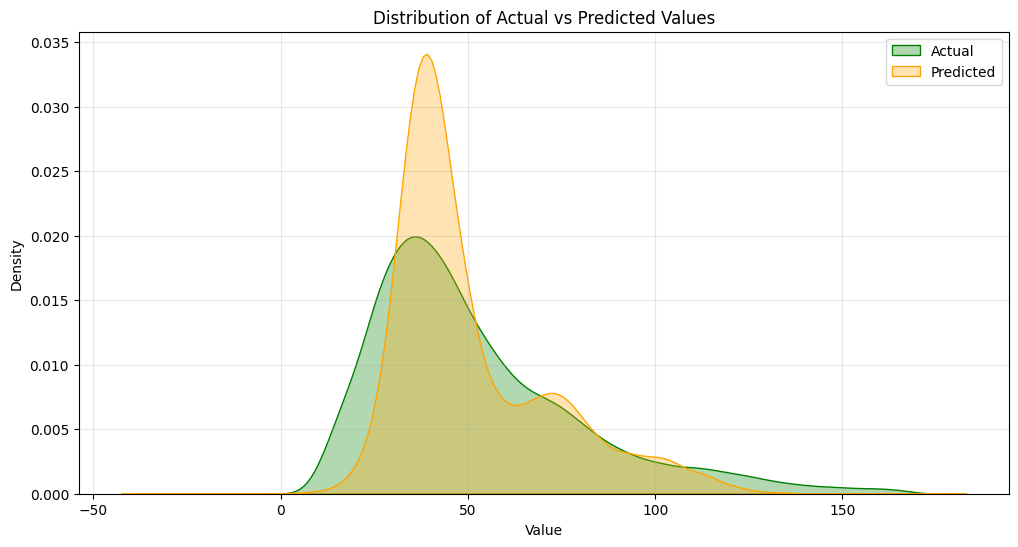

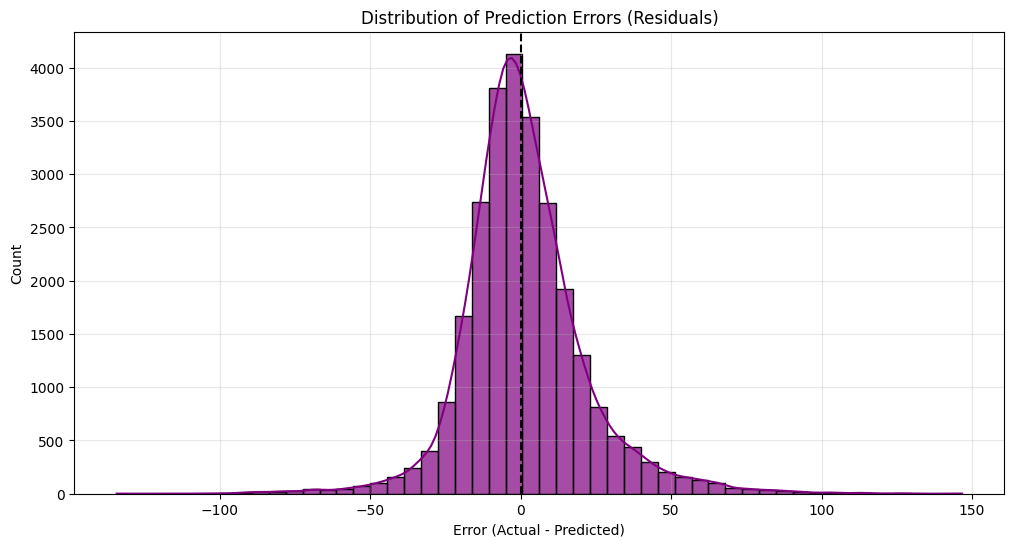

In [25]:
result_df  = utils.create_results_df(f"{model_name}.keras", test_dataset, train_mean[1], train_std[1])

utils.plot_predictions_and_errors(result_df)

# Simple LSTM

In [26]:
model_name = 'simple_lstm'

# model architecture
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

x = layers.LSTM(32)(inputs)

x = layers.Dropout(0.2)(x)

outputs = layers.Dense(1)(x)
lstm_model = keras.Model(inputs, outputs)

# Add the training call here
history = run_experiment(
    model=lstm_model,
    train_ds=train_dataset,
    val_ds=val_dataset,
    model_name=model_name,
    epochs=50,
    patience=5
)


Starting training for: simple_lstm
Epoch 1/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 4.5535 - mae: 5.0289 - val_loss: 2.5352 - val_mae: 2.9944
Epoch 2/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 2.5755 - mae: 3.0344 - val_loss: 2.3200 - val_mae: 2.7746
Epoch 3/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 2.4359 - mae: 2.8924 - val_loss: 2.2516 - val_mae: 2.7059
Epoch 4/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 2.3705 - mae: 2.8258 - val_loss: 2.2103 - val_mae: 2.6629
Epoch 5/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 2.3519 - mae: 2.8061 - val_loss: 2.2045 - val_mae: 2.6583
Epoch 6/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 2.3312 - mae: 2.7855 - val_loss: 2.1772 - val_mae: 2.6298
Epoch 7/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 2.3123 - mae: 2.7651 - val_loss: 2.1646 - val_mae: 2.6169
Epoch 8/50
424/424 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 2.3018 - mae: 2.7540 - val_loss: 2.1541 - val_mae: 2.6062
Epoch 9/50
4

In [27]:
utils.evaluate_model(f"{model_name}.keras", test_dataset)

Loading best model from: simple_lstm.keras
Evaluating model on test set...
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.0468 - mae: 2.4935
Test MAE: 2.4247


2.424713373184204

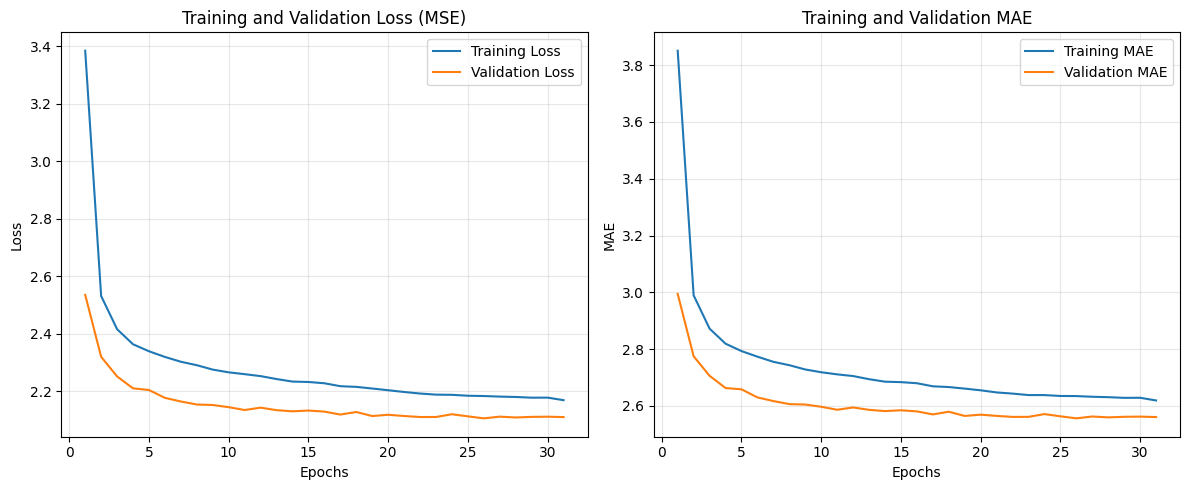

In [28]:
utils.plot_training_history(history, metrics=['mae'])

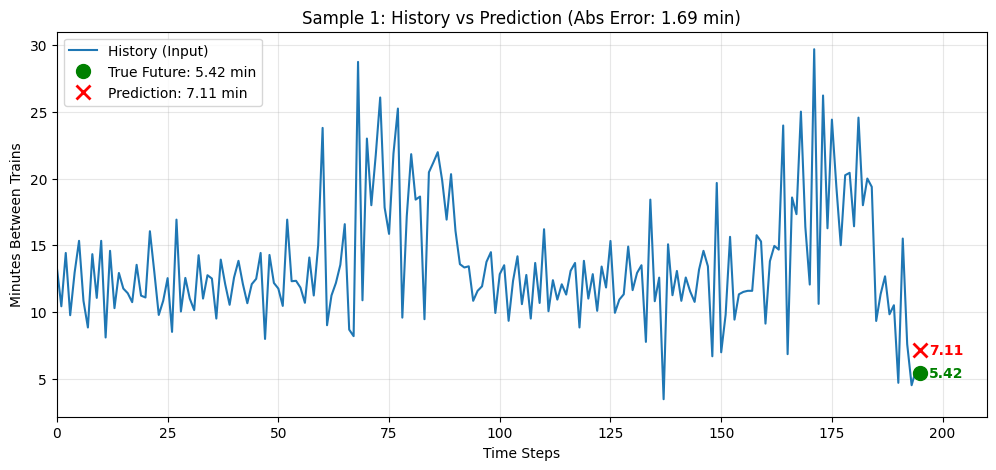

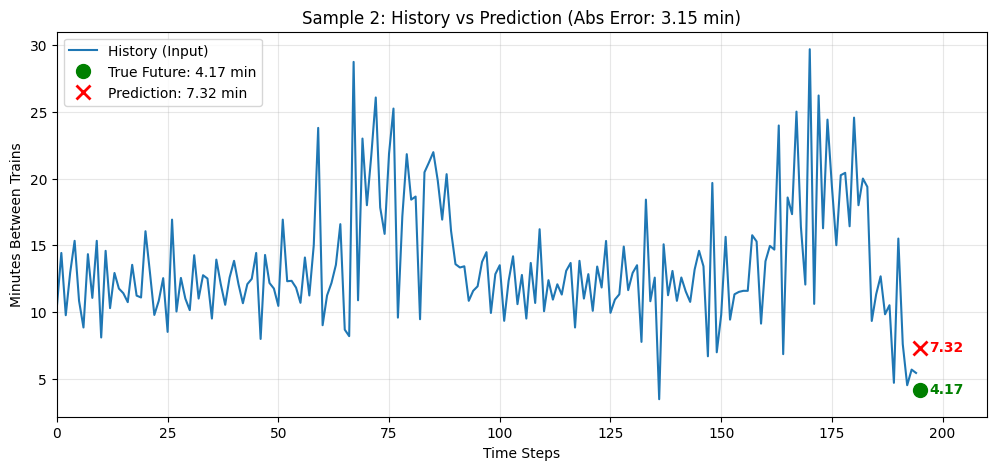

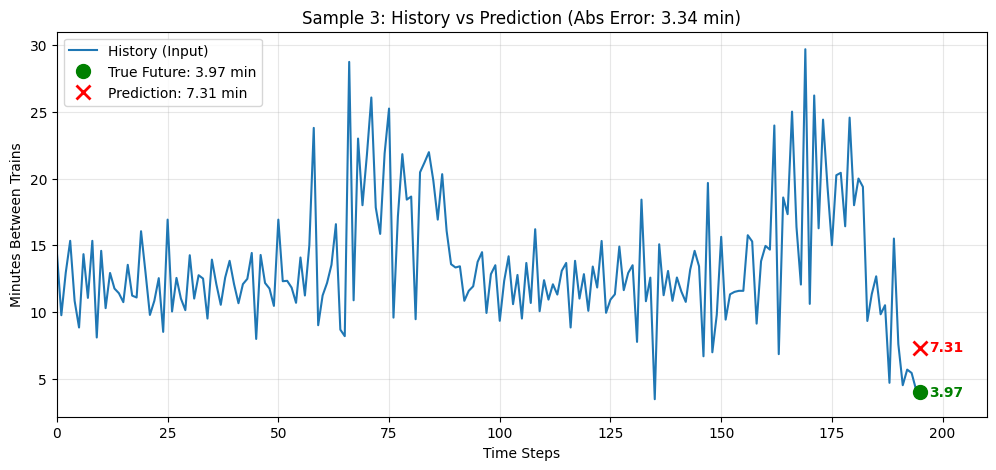

In [29]:
# Use model_name as path for forecast context and prediction distribution
utils.plot_forecast_context(
    model_path=f"{model_name}.keras",
    dataset=test_dataset,
    train_mean=train_mean,
    train_std=train_std,
    num_samples=3  # Optional: How many examples to plot
)

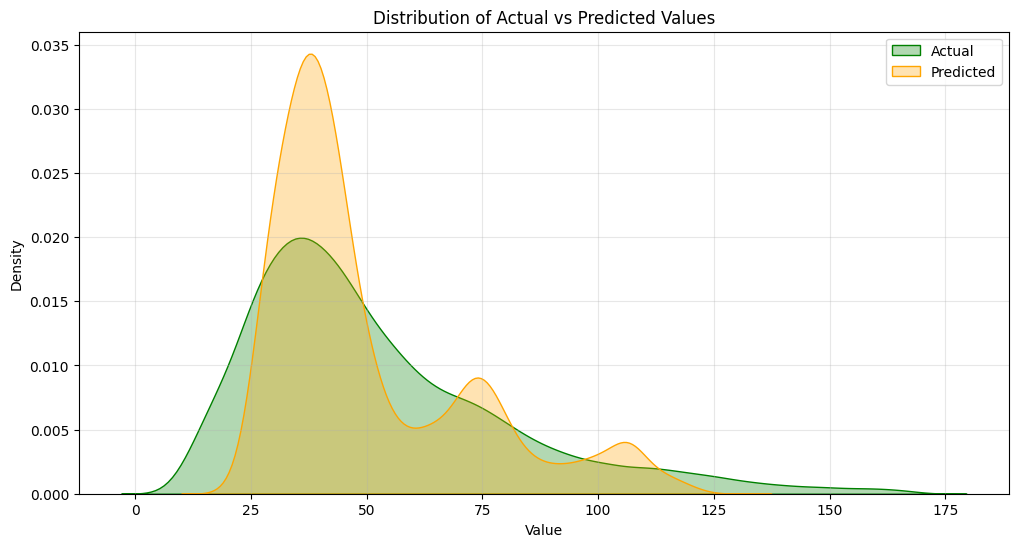

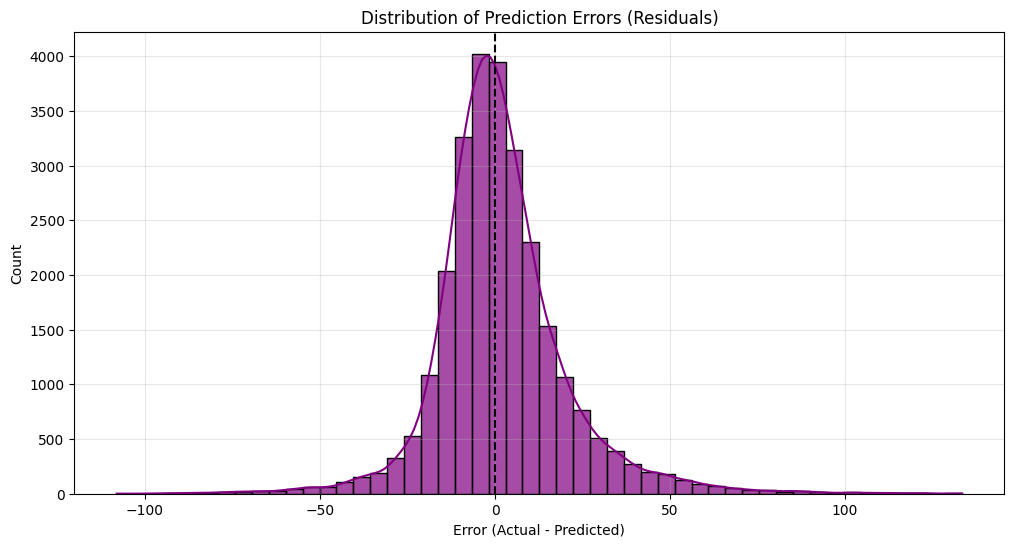

In [30]:
result_df  = utils.create_results_df(f"{model_name}.keras", test_dataset, train_mean[1], train_std[1])

utils.plot_predictions_and_errors(result_df)

# Using Spacial Dropout to Fight Overfitting

In [31]:
model_name = 'optimized_gru'
# --- Optimized GRU (Removed Regularizers, Added LayerNorm) ---
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# Layer 1: GRU
# Removed L2 Regularization as requested
x = layers.GRU(64, return_sequences=True)(inputs)
x = layers.LayerNormalization()(x) # Added for stability
x = layers.SpatialDropout1D(0.3)(x) # Better for sequences than standard Dropout

# Layer 2: GRU
x = layers.GRU(64, return_sequences=True)(x)
x = layers.LayerNormalization()(x)
x = layers.SpatialDropout1D(0.3)(x)

# Layer 3: GRU
x = layers.GRU(32, return_sequences=False)(x)
x = layers.LayerNormalization()(x)
x = layers.Dropout(0.2)(x)

# Dense Head
outputs = layers.Dense(1)(x)

stacked_gru = keras.Model(inputs=inputs, outputs=outputs, name="optimized_gru")

# Use your experiment runner
history_srg = run_experiment(
    model=stacked_gru,
    train_ds=train_dataset,
    val_ds=val_dataset,
    model_name=model_name,
    epochs=100,
    patience=8) # Increased patience slightly


Starting training for: optimized_gru
Epoch 1/100
424/424 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 3.6405 - mae: 4.1087 - val_loss: 2.4585 - val_mae: 2.9165
Epoch 2/100
424/424 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 2.6119 - mae: 3.0725 - val_loss: 2.2296 - val_mae: 2.6796
Epoch 3/100
424/424 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 2.4402 - mae: 2.8964 - val_loss: 2.1725 - val_mae: 2.6240
Epoch 4/100
424/424 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 2.3586 - mae: 2.8136 - val_loss: 2.1436 - val_mae: 2.5942
Epoch 5/100
424/424 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 2.3263 - mae: 2.7800 - val_loss: 2.1023 - val_mae: 2.5517
Epoch 6/100
424/424 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 2.2996 - mae: 2.7533 - val_loss: 2.0963 - val_mae: 2.5462
Epoch 7/100
424/424 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 2.2818 - mae: 2.7345 - val_loss: 2.0868 - val_mae: 2.5373
Epoch 8/100
424/424 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - loss: 2.2597 - mae: 2.7118 - val_loss: 2.0646 - val_mae: 2

In [32]:
utils.evaluate_model(f"{model_name}.keras", test_dataset)

Loading best model from: optimized_gru.keras
Evaluating model on test set...
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.9889 - mae: 2.4332
Test MAE: 2.3726


2.372572183609009

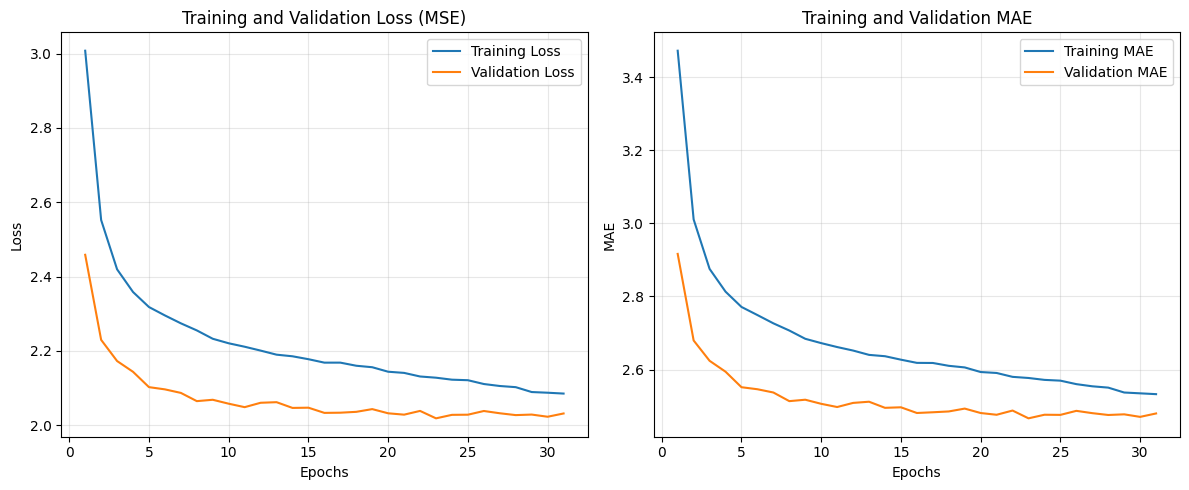

In [33]:
utils.plot_training_history(history_srg, metrics=['mae'])

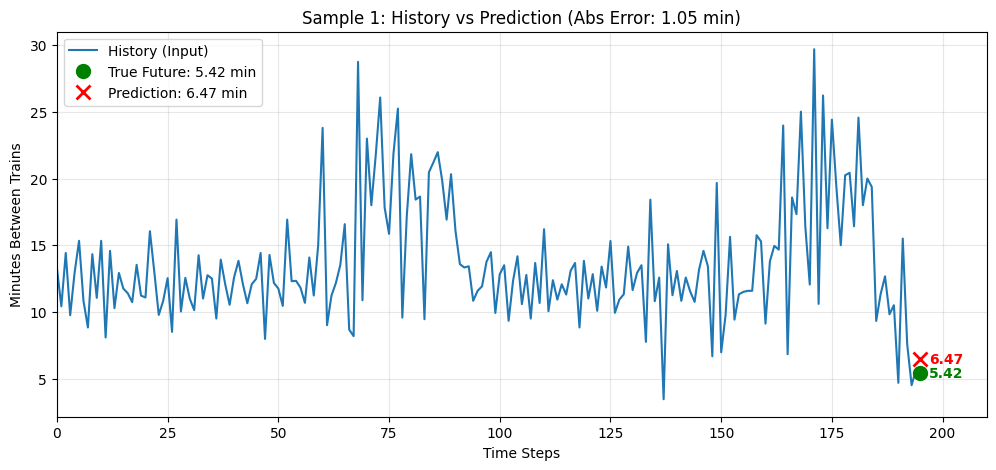

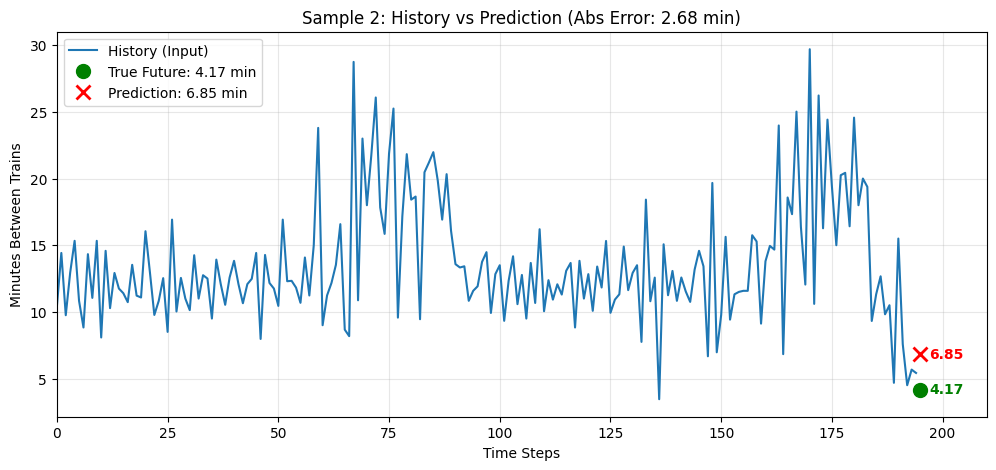

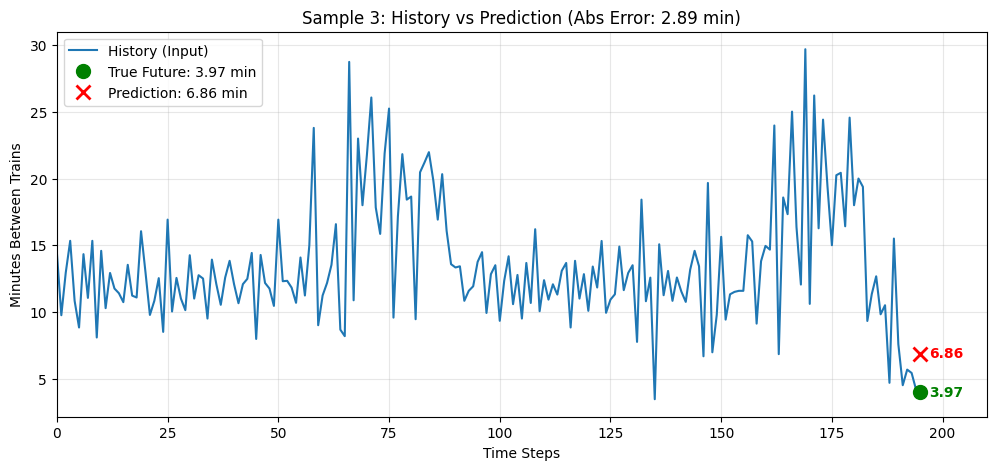

In [34]:
# Use model_name as path for forecast context and prediction distribution
utils.plot_forecast_context(
    model_path=f"{model_name}.keras",
    dataset=test_dataset,
    train_mean=train_mean,
    train_std=train_std,
    num_samples=3  # Optional: How many examples to plot
)


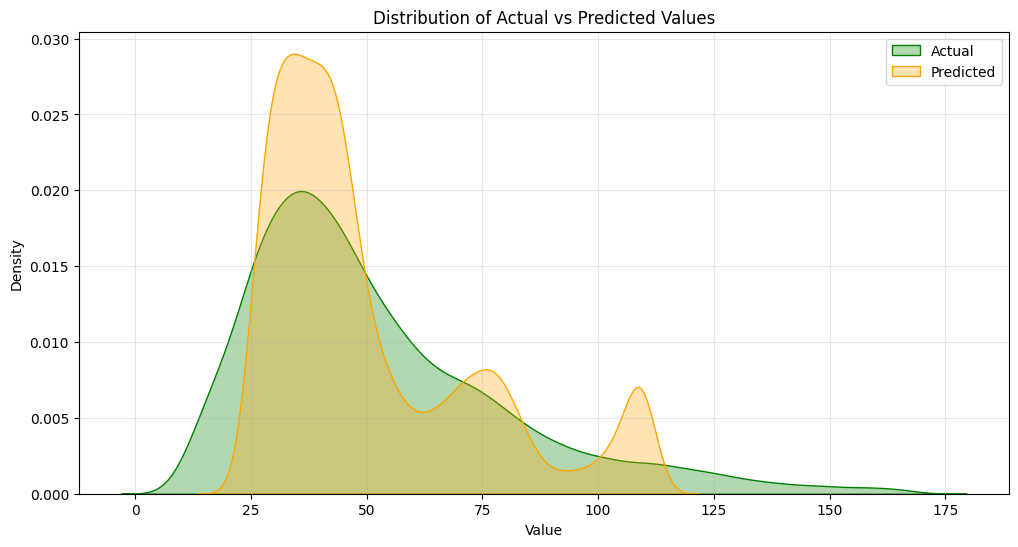

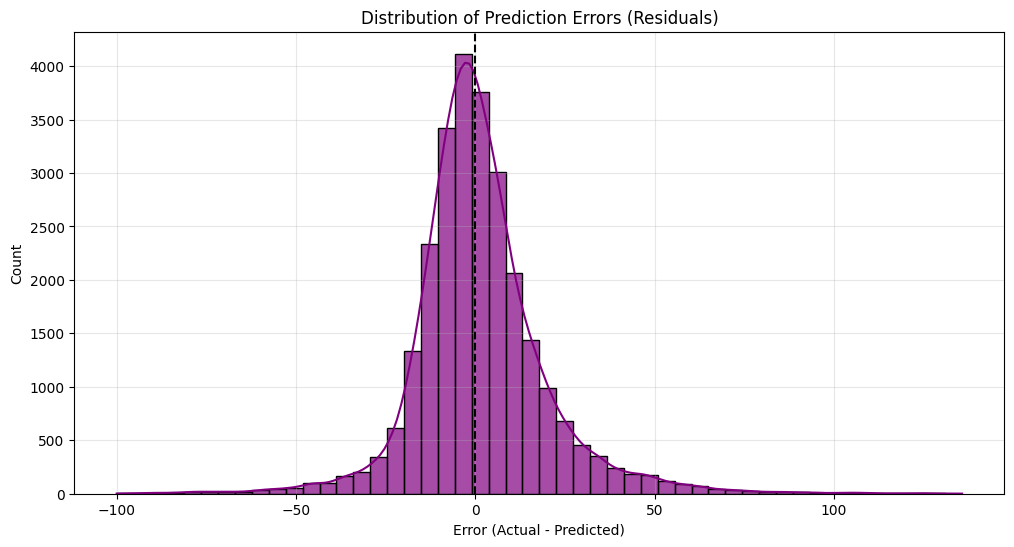

In [35]:
result_df  = utils.create_results_df(f"{model_name}.keras", test_dataset, train_mean[1], train_std[1])

utils.plot_predictions_and_errors(result_df)